$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
$$

## Simple implementation of the recirculation algorithm

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from scipy.special import expit as sigmoid

sns.set(style="white", color_codes=True)

np.random.seed(42)

In [2]:
class Layer:
    def __init__(self, input_size, output_size, activation_fn, include_bias=False):
        self._i = input_size
        self._o = output_size
        self._fn = activation_fn
        self._include_bias = include_bias
        
        self._output = None
        self._initialise_params()
    
    def _initialise_params(self):
        self._W = np.random.uniform(low=-0.5, high=0.5, size=(self._o, self._i))
        if self._include_bias:
            self._b = np.random.uniform(low=-0.5, high=0.5, size=(self._o, 1))
        
    def _compute_activities(self, x):
        assert len(x.shape) == 2, "received input of shape {}".format(x.shape)
        assert x.shape[1] == self._i, "received input of shape {}, expected 2nd dim {}".format(x.shape, self._i)
        
        activity = x @ self._W.T
        if self._include_bias:
            activity += self._b.T
        return self._fn(activity)
            
    def __call__(self, x, reg=None, l=0.0):
        self._input = x
        if reg is None:
            self._output = self._compute_activities(x)
        else:
            self._output = l * reg + (1.0 - l) * self._compute_activities(x)
        return self._output
    
    def learn(self, true_input, previous_output, lr):
        gradient_estimate = previous_output - self._output
        self._W += lr * gradient_estimate.T @ true_input
        if self._include_bias:
            self._b += lr * gradient_estimate.T @ np.ones((true_input.shape[0], 1))
            
    def weight(self):
        return self._W.copy()

In [3]:
class AutoEncoder:
    def __init__(self, visible_size, hidden_size):
        self._V = visible_size
        self._H = hidden_size
        self._build_network()
        
    def _build_network(self):
        self._encoder = Layer(self._V, self._H, sigmoid, True)
        self._decoder = Layer(self._H, self._V, sigmoid, True)
    
    def _encode(self, x, reg=None, l=0.0):
        return self._encoder(x, reg, l)
    
    def _decode(self, x, reg=None, l=0.0):
        return self._decoder(x, reg, l)
        
    def learn(self, true_inputs, l, lr):
        code = self._encode(true_inputs, None, l)
        reconstruction = self._decode(code, true_inputs, l)
        
        self._decoder.learn(code, true_inputs, lr)
        
        recode = self._encode(reconstruction, code, l)
        
        self._encoder.learn(reconstruction, code, lr)
        
    def reconstruct(self, true_inputs):
        return self._decode(self._encode(true_inputs))
        
    def evaluate(self, true_inputs):
        reconstruction = self.reconstruct(true_inputs)
        return 0.5 * np.mean(np.sum(np.square(reconstruction - true_inputs), axis=1))
    
    def weight_alignment(self):
        encW = self._encoder.weight()
        decW = self._decoder.weight().T
        encW /= np.linalg.norm(encW, axis=1, keepdims=True)
        decW /= np.linalg.norm(decW, axis=1, keepdims=True)
        angles = np.diag(encW @ decW.T)
        angles = np.arccos(angles) * 180 / np.pi
        return np.max(angles)

In [12]:
X = np.eye(4)
N = 50

In [13]:
ae = AutoEncoder(4, 2)
losses, alignments = [], []
for _ in range(N):
    ae.learn(X, 0.75, 20)
    loss = ae.evaluate(X)
    losses.append(loss)
    alignments.append(ae.weight_alignment())
    if loss < 1e-3:
        break

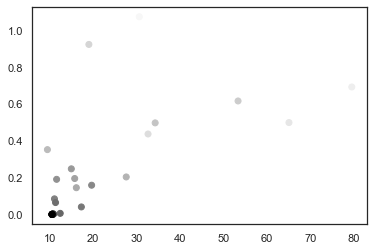

In [15]:
color = cm.binary(np.linspace(0, 1, len(losses)))
plt.scatter(alignments, losses, c=color)
plt.show()